# Topic: Fine-tuning the DebertaV3 model for LLM-Classification.

Using the Shared Weight strategy with KerasNLP. This competition can predict which responses users will prefer in a head-to-head battle between chatbots powered by large language models (LLMs). There is a dataset of conversations from the Chatbot Arena, where different LLMs generate answers to user prompts. By developing a machine learning model, we have to improve how chatbots interact with humans and ensure they better align with human preferences.

# Description

Large language models (LLMs) are rapidly entering our lives, but ensuring their responses resonate with users is critical for successful interaction. This competition presents a unique opportunity to tackle this challenge with real-world data and help us bridge the gap between LLM capability and human preference.

We utilized a large dataset collected from Chatbot Arena, where users chat with two anonymous LLMs and choose the answer they prefer. Your task in this competition is to predict which response a user will prefer in these head-to-head battles.

This challenge aligns with the concept of "reward models" or "preference models" in reinforcement learning from human feedback (RLHF). Previous research has identified limitations in directly prompting an existing LLM for preference predictions. These limitations often stem from biases such as favoring responses presented first (position bias), being overly verbose (verbosity bias), or exhibiting self-promotion (self-enhancement bias).

Our work will be instrumental in developing LLMs that can tailor responses to individual user preferences, ultimately leading to more user-friendly and widely accepted AI-powered conversation systems.


# Data Source


The competition dataset consists of user interactions from the ChatBot Arena. In each user interaction a judge provides one or more prompts to two different large language models, and then indicates which of the models gave the more satisfactory response. The goal of the competition is to predict the preferences of the judges and determine the likelihood that a given prompt/response pair is selected as the winner.

There are 55K rows in the training data and 25,000 rows in the test set.


# Citation
Wei-lin Chiang, Lianmin Zheng, Lisa Dunlap, Joseph E. Gonzalez, Ion Stoica, Paul Mooney, Sohier Dane, Addison Howard, and Nate Keating. LLM Classification Finetuning. https://kaggle.com/competitions/llm-classification-finetuning, 2024. Kaggle.

https://www.kaggle.com/code/awsaf49/llm-science-exam-kerascore-kerasnlp-tpu

https://www.kaggle.com/code/awsaf49/aes-2-0-kerasnlp-starter

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
BASE_PATH = '/kaggle/input/llm-classification-finetuning'

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/deberta_v3/keras/deberta_v3_extra_small_en/2/config.json
/kaggle/input/deberta_v3/keras/deberta_v3_extra_small_en/2/tokenizer.json
/kaggle/input/deberta_v3/keras/deberta_v3_extra_small_en/2/metadata.json
/kaggle/input/deberta_v3/keras/deberta_v3_extra_small_en/2/model.weights.h5
/kaggle/input/deberta_v3/keras/deberta_v3_extra_small_en/2/assets/tokenizer/vocabulary.spm
/kaggle/input/llm-classification-finetuning/sample_submission.csv
/kaggle/input/llm-classification-finetuning/train.csv
/kaggle/input/llm-classification-finetuning/test.csv


First, Let's import all the libraries we need.

In [ ]:
import keras_nlp
import keras
import tensorflow as tf
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split  

We create a class Configuration defining configuration parameters for a machine learning model training setup, including settings like seed, model preset, sequence length, epochs, and label mappings.

In [ ]:
class Configuration:
    seed = 42  
    preset = "deberta_v3_extra_small_en" 
    sequence_length = 512  
    epochs = 3 
    batch_size = 16  
    scheduler = 'cosine'  
    label2name = {0: 'winner_model_a', 1: 'winner_model_b', 2: 'winner_tie'}
    name2label = {v:k for k, v in label2name.items()}
    class_labels = list(label2name.keys())
    class_names = list(label2name.values())

keras.utils.set_random_seed(Configuration.seed)
#This can speed up training by reducing memory usage and increasing the computation speed, while maintaining enough precision to train the model effectively.
keras.mixed_precision.set_global_policy("mixed_float16")

# Load the training data and testing data

In [ ]:
# Load Train Data
df = pd.read_csv(f'{BASE_PATH}/train.csv') 

# Take the first prompt and its associated response
df["prompt"] = df.prompt.map(lambda x: eval(x)[0])
df["response_a"] = df.response_a.map(lambda x: eval(x.replace("null","''"))[0])
df["response_b"] = df.response_b.map(lambda x: eval(x.replace("null", "''"))[0])

# Label conversion
df["class_name"] = df[["winner_model_a", "winner_model_b" , "winner_tie"]].idxmax(axis=1)
df["class_label"] = df.class_name.map(Configuration.name2label)

# Show Sample
df.head()

id             model_a              model_b  \
0   30192  gpt-4-1106-preview           gpt-4-0613   
1   53567           koala-13b           gpt-4-0613   
2   65089  gpt-3.5-turbo-0613       mistral-medium   
3   96401    llama-2-13b-chat  mistral-7b-instruct   
4  198779           koala-13b   gpt-3.5-turbo-0314   

                                              prompt  \
0  Is it morally right to try to have a certain p...   
1  What is the difference between marriage licens...   
2  explain function calling. how would you call a...   
3  How can I create a test set for a very rare ca...   
4  What is the best way to travel from Tel-Aviv t...   

                                          response_a  \
0  The question of whether it is morally right to...   
1  A marriage license is a legal document that al...   
2  Function calling is the process of invoking or...   
3  Creating a test set for a very rare category c...   
4  The best way to travel from Tel Aviv to Jerusa...   

                                          response_b  winner_model_a  \
0  As an AI, I don't have personal beliefs or opi...               1   
1  A marriage license and a marriage certificate ...               0   
2  Function calling is the process of invoking a ...               0   
3  When building a classifier for a very rare cat...               1   
4  The best way to travel from Tel-Aviv to Jerusa...               0   

   winner_model_b  winner_tie      class_name  class_label  
0               0           0  winner_model_a            0  
1               1           0  winner_model_b            1  
2               0           1      winner_tie            2  
3               0           0  winner_model_a            0  
4               1           0  winner_model_b            1

In [9]:
# Load Test Data
test_df = pd.read_csv(f'{BASE_PATH}/test.csv')

# Take the first prompt and response
test_df["prompt"] = test_df.prompt.map(lambda x: eval(x)[0])
test_df["response_a"] = test_df.response_a.map(lambda x: eval(x.replace("null","''"))[0])
test_df["response_b"] = test_df.response_b.map(lambda x: eval(x.replace("null", "''"))[0])

# Show Sample
test_df.head()

id                                             prompt  \
0   136060  I have three oranges today, I ate an orange ye...   
1   211333  You are a mediator in a heated political debat...   
2  1233961  How to initialize the classification head when...   

                                          response_a  \
0                        You have two oranges today.   
1  Thank you for sharing the details of the situa...   
2  When you want to initialize the classification...   

                                          response_b  
0  You still have three oranges. Eating an orange...  
1  Mr Reddy and Ms Blue both have valid points in...  
2  To initialize the classification head when per...

# Contextualize Response with Prompt(Data cleaning)
we will contextualize each response with the prompt instead of using a single prompt for all responses. This means that for each response, we will provide the model with the same set of prompts combined with their respective response. This approach is similar to the multiple-choice question task in NLP.

In [10]:
# Define a function to create options based on the prompt and choices
def make_pairs(row):
    row["encode_fail"] = False
    try:
        prompt = row.prompt.encode("utf-8").decode("utf-8")
    except:
        prompt = ""
        row["encode_fail"] = True

    try:
        response_a = row.response_a.encode("utf-8").decode("utf-8")
    except:
        response_a = ""
        row["encode_fail"] = True

    try:
        response_b = row.response_b.encode("utf-8").decode("utf-8")
    except:
        response_b = ""
        row["encode_fail"] = True
        
    row['options'] = [f"Prompt: {prompt}\n\nResponse: {response_a}",  # Response from Model A
                      f"Prompt: {prompt}\n\nResponse: {response_b}"  # Response from Model B
                     ]
    return row

In [ ]:
df = df.apply(make_pairs, axis=1)  
display(df.head(2)) 

test_df = test_df.apply(make_pairs, axis=1)  
display(test_df.head(2))  

id             model_a     model_b  \
0  30192  gpt-4-1106-preview  gpt-4-0613   
1  53567           koala-13b  gpt-4-0613   

                                              prompt  \
0  Is it morally right to try to have a certain p...   
1  What is the difference between marriage licens...   

                                          response_a  \
0  The question of whether it is morally right to...   
1  A marriage license is a legal document that al...   

                                          response_b  winner_model_a  \
0  As an AI, I don't have personal beliefs or opi...               1   
1  A marriage license and a marriage certificate ...               0   

   winner_model_b  winner_tie      class_name  class_label  encode_fail  \
0               0           0  winner_model_a            0        False   
1               1           0  winner_model_b            1        False   

                                             options  
0  [Prompt: Is it morally right to try to have a ...  
1  [Prompt: What is the difference between marria...

id                                             prompt  \
0  136060  I have three oranges today, I ate an orange ye...   
1  211333  You are a mediator in a heated political debat...   

                                          response_a  \
0                        You have two oranges today.   
1  Thank you for sharing the details of the situa...   

                                          response_b  encode_fail  \
0  You still have three oranges. Eating an orange...        False   
1  Mr Reddy and Ms Blue both have valid points in...        False   

                                             options  
0  [Prompt: I have three oranges today, I ate an ...  
1  [Prompt: You are a mediator in a heated politi...

# Exploratory Data Analysis (EDA)

First, we draw a plot of distribution of LLMs

In [13]:
model_df = pd.concat([df.model_a, df.model_b])
counts = model_df.value_counts().reset_index()
counts.columns = ['LLM', 'Count']

# Create a bar plot with custom styling using Plotly
fig = px.bar(counts, x='LLM', y='Count',
             title='Distribution of LLMs',
             color='Count', color_continuous_scale='viridis')

fig.update_layout(xaxis_tickangle=-45)  # Rotate x-axis labels for better readability

fig.show()

As we can see from the chart above, gpt-4-1106, gpt-4-0613, claude-instant-1 rank the first 3 distribution of LLMs.

Second, we draw a plot of winner distribution of train data.

In [14]:
counts = df['class_name'].value_counts().reset_index()
counts.columns = ['Winner', 'Win Count']

fig = px.bar(counts, x='Winner', y='Win Count',
             title='Winner distribution for Train Data',
             labels={'Winner': 'Winner', 'Win Count': 'Win Count'},
             color='Winner', color_continuous_scale='viridis')

fig.update_layout(xaxis_title="Winner", yaxis_title="Win Count")

fig.show()

 It indicates that the win counts for winner_model_a and winner_model_b are close, while winner_tie has slightly fewer wins.

# Data split

In [ ]:
train_df, valid_df = train_test_split(df, test_size=0.2, stratify=df["class_label"])

# Preprocessing

The preprocessor takes input strings and transforms them into a dictionary (token_ids, padding_mask) containing preprocessed tensors. This process starts with tokenization, where input strings are converted into sequences of token IDs.

Initially, raw text data is complex and challenging for modeling due to its high dimensionality. By converting text into a compact set of tokens, such as transforming "The quick brown fox" into ["the", "qu", "##ick", "br", "##own", "fox"], we simplify the data. Many models rely on special tokens and additional tensors to understand input. These tokens help divide input and identify padding, among other tasks. Making all sequences the same length through padding boosts computational efficiency, making subsequent steps smoother.

In [ ]:
preprocessor = keras_nlp.models.DebertaV3Preprocessor.from_preset(
    preset=Configuration.preset, # Name of the model
    sequence_length=Configuration.sequence_length, # Max sequence length, will be padded if shorter
)

In [17]:
outs = preprocessor(df.options.iloc[0])  # Process options for the first row

# Display the shape of each processed output
for k, v in outs.items():
    print(k, ":", v.shape)

token_ids : (2, 512)
padding_mask : (2, 512)


We'll use the preprocessing function to transform each text option.

In [ ]:
def preprocess(text, label=None):
    text = preprocessor(text)  # Preprocess text
    return (text, label) if label is not None else text  # Return processed text and label if available

The code below sets up a robust data flow pipeline using tf.data.Dataset for data processing. Notable aspects of tf.data include its ability to simplify pipeline construction and represent components in sequences.

# Build Train/Valid Dataloader

In [ ]:
def build_dataset(texts, labels=None, batch_size=32,
                  cache=True, shuffle=1024):
    AUTO = tf.data.AUTOTUNE  # AUTOTUNE option
    slices = (texts,) if labels is None else (texts, keras.utils.to_categorical(labels, num_classes=3))  # Create slices
    ds = tf.data.Dataset.from_tensor_slices(slices)  # Create dataset from slices
    ds = ds.cache() if cache else ds  # Cache dataset if enabled
    ds = ds.map(preprocess, num_parallel_calls=AUTO)  # Map preprocessing function
    opt = tf.data.Options()  # Create dataset options
    if shuffle: 
        ds = ds.shuffle(shuffle, seed=Configuration.seed)  # Shuffle dataset if enabled
        opt.experimental_deterministic = False
    ds = ds.with_options(opt)  # Set dataset options
    ds = ds.batch(batch_size, drop_remainder=False)  # Batch dataset
    ds = ds.prefetch(AUTO)  # Prefetch next batch
    return ds  # Return the built dataset

In [ ]:
# Train
train_texts = train_df.options.tolist()  # Extract training texts
train_labels = train_df.class_label.tolist()  # Extract training labels
train_ds = build_dataset(train_texts, train_labels,
                         batch_size=Configuration.batch_size,
                         shuffle=True)

# Valid
valid_texts = valid_df.options.tolist()  # Extract validation texts
valid_labels = valid_df.class_label.tolist()  # Extract validation labels
valid_ds = build_dataset(valid_texts, valid_labels,
                         batch_size=Configuration.batch_size,
                         shuffle=False)

# LR Schedule

Implementing a learning rate scheduler is crucial for transfer learning. The learning rate initiates at lr_start and gradually tapers down to lr_min using various techniques, including:

step: Lowering the learning rate in step-wise manner resembling stairs.
cos: Utilizing a cosine curve to gradually reduce the learning rate.
exp: Exponentially decreasing the learning rate.

In [21]:
import math

def get_lr_callback(batch_size=8, mode='cos', epochs=10, plot=False):
    lr_start, lr_max, lr_min = 1.0e-6, 0.6e-6 * batch_size, 1e-6
    lr_ramp_ep, lr_sus_ep, lr_decay = 2, 0, 0.8

    def lrfn(epoch):  # Learning rate update function
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr

    if plot:  # Plot lr curve if plot is True
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()

    return keras.callbacks.LearningRateScheduler(lrfn, verbose=False)  # Create lr callback

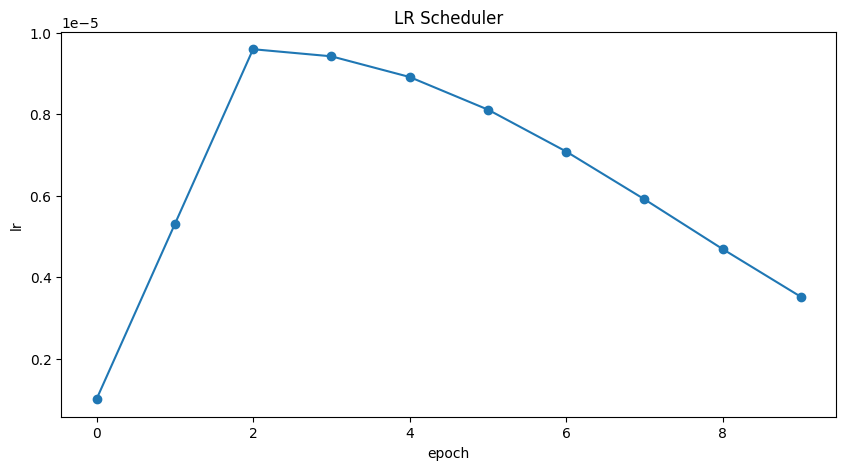

In [ ]:
lr_cb = get_lr_callback(Configuration.batch_size, plot=True)

The following code will create a callback that will save the best checkpoint of the model during training, which we will use for inference in the submission.

In [23]:
ckpt_cb = keras.callbacks.ModelCheckpoint(f'best_model.weights.h5',
                                          monitor='val_log_loss',
                                          save_best_only=True,
                                          save_weights_only=True,
                                          mode='min')  # Get Model checkpoint callback

The metric for this competition is Log Loss. 

Note that this metric is similar to categorical cross entropy widely used in classification tasks. The Keras library already has an implementation of this metric, we will simply use the metric to monitor performance of our model.

In [24]:
log_loss = keras.metrics.CategoricalCrossentropy(name="log_loss")

# Modeling

The KerasNLP library provides various NLP model architectures such as Bert, Roberta, DebertaV3, and more. We have chose the DebertaV3.

Our approach utilizes keras_nlp.models.DebertaV3Classifier to process each prompt and response pair, generating output embeddings. We then concatenate these embeddings and pass them through a Pooling layer and a classifier to obtain logits, followed by a softmax function for the final output.

When dealing with multiple responses, we use a weight-sharing strategy. This means we provide the model with one response at a time along with the prompt (P + R_A), (P + R_B), etc., using the same model weights for all responses. After obtaining embeddings for all responses, we concatenate them and apply average pooling. Next, we use a Linear/Dense layer along with the Softmax function as the classifier for the final result. Providing all responses at once would increase text length and complicate model handling. In the classifier, we use 3 classes for winner_model_a, winner_model_b, and draw cases.

In [ ]:
# Define input layers
inputs = {
    "token_ids": keras.Input(shape=(2, None), dtype=tf.int32, name="token_ids"),
    "padding_mask": keras.Input(shape=(2, None), dtype=tf.int32, name="padding_mask"),
}
# Create a DebertaV3Classifier backbone
backbone = keras_nlp.models.DebertaV3Backbone.from_preset(
    Configuration.preset,
)

# Compute embeddings for first response: (P + R_A) using backbone
response_a = {k: v[:, 0, :] for k, v in inputs.items()}
embed_a = backbone(response_a)

# Compute embeddings for second response: (P + R_B), using the same backbone
response_b = {k: v[:, 1, :] for k, v in inputs.items()}
embed_b = backbone(response_b)

# Compute final output
embeds = keras.layers.Concatenate(axis=-1)([embed_a, embed_b])
embeds = keras.layers.GlobalAveragePooling1D()(embeds)
outputs = keras.layers.Dense(3, activation="softmax", name="classifier")(embeds)
model = keras.Model(inputs, outputs)

# Compile the model with optimizer, loss, and metrics
model.compile(
    optimizer=keras.optimizers.Adam(5e-6),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.02),
    metrics=[
        log_loss,
        keras.metrics.CategoricalAccuracy(name="accuracy"),
    ],
)

# Model summary

In [26]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ padding_mask        │ (None, 2, None)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_ids           │ (None, 2, None)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, None)      │          0 │ padding_mask[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, None)      │          0 │ token_ids[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_3          │ (None, None)      │          0 │ padding_mask[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, None)      │          0 │ token_ids[0][0]   │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ deberta_v3_backbone │ (None, None, 384) │ 70,682,112 │ get_item_1[0][0], │
│ (DebertaV3Backbone) │                   │            │ get_item[0][0],   │
│                     │                   │            │ get_item_3[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, None, 768) │          0 │ deberta_v3_backb… │
│ (Concatenate)       │                   │            │ deberta_v3_backb… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 768)       │          0 │ concatenate[0][0] │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classifier (Dense)  │ (None, 3)         │      2,307 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 70,684,419 (269.64 MB)

 Trainable params: 70,684,419 (269.64 MB)

 Non-trainable params: 0 (0.00 B)

# Training

In [ ]:
# Start training the model
history = model.fit(
    train_ds,
    epochs=Configuration.epochs,
    validation_data=valid_ds,
    callbacks=[lr_cb, ckpt_cb]
)

Epoch 1/3
2874/2874 ━━━━━━━━━━━━━━━━━━━━ 3221s 1s/step - accuracy: 0.3922 - log_loss: 1.1481 - loss: 1.1492 - val_accuracy: 0.4388 - val_log_loss: 1.0638 - val_loss: 1.0657 - learning_rate: 1.0000e-06
Epoch 2/3
2874/2874 ━━━━━━━━━━━━━━━━━━━━ 3129s 1s/step - accuracy: 0.4422 - log_loss: 1.0632 - loss: 1.0653 - val_accuracy: 0.4650 - val_log_loss: 1.0421 - val_loss: 1.0447 - learning_rate: 5.3000e-06
Epoch 3/3
2874/2874 ━━━━━━━━━━━━━━━━━━━━ 3103s 1s/step - accuracy: 0.4646 - log_loss: 1.0392 - loss: 1.0421 - val_accuracy: 0.4661 - val_log_loss: 1.0337 - val_loss: 1.0368 - learning_rate: 9.6000e-06


In [28]:
model.load_weights('/kaggle/working/best_model.weights.h5')

In [ ]:
# Build test dataset
test_texts = test_df.options.tolist()
test_ds = build_dataset(test_texts,
                         batch_size=min(len(test_df), Configuration.batch_size),
                         shuffle=False)

In [30]:
# Make predictions using the trained model on test data
test_preds = model.predict(test_ds, verbose=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


# Submission

In [ ]:
sub_df = test_df[["id"]].copy()
sub_df[Configuration.class_names] = test_preds.tolist()
sub_df.to_csv("submission.csv", index=False)
sub_df.head()

id  winner_model_a  winner_model_b  winner_tie
0   136060        0.243286        0.266357    0.490479
1   211333        0.268799        0.333740    0.397217
2  1233961        0.169678        0.449951    0.380127

# Conclusion

I complished the Fine-tuning DebertaV3 model for LLM-Classification. I achieved a good score with a small model and modest token length. 
And next time, if I have the better resource, I will try:

1. Try bigger models like Deberta-Base or Deberta-Small, or LLMs like Gemma.
2. Increase max token length to reduce loss of data.
3. Train for more epochs.